In [360]:
import pandas as pd
import numpy as np

import yfinance as yf
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
test_set_len = .1

import riskfolio as rp

### Overview
In this notebook, we explore and implement a portfolio construction method know as Hierarcal Risk Parity.
The three steps in this algorithm are:
- Clustering
- Matrix Seriation
- Recursive Bisection

In this implementation, we will use daily Vangaurd sector ETF data from yfinance.

Finally, we will test the performance of this method versus the well-know mean-variance Markowitz model.

#### Data Import

- VCLT: Long-term IG Corportate
- VCIT: Intermediate IG Corporate
- VCSH: Short-term IG Corportate
- VCR: Consumer Discretionary
- VXUS: Total International ETF
- VDE: Energy
- VFH: Financials
- VHT: Health Care
- VIS: Industrials
- VNQ: Real Estate
- VPU: Utilities
- VGIT: Intermediate US Treasury
- VGLT: Long-term US Treasury
- VGSH: Short-term US Treasury

In [433]:
def get_data() -> pd.DataFrame:
    """
    Using sector tickers, makes yfinance API call to get daily stock data, and calculates returns
    ---------
    Returns:
    - returns for sector tickers
    """
    sector_tickers = "VCLT VCIT VCSH VCR VXUS VDE VFH VHT VIS VNQ VPU VGIT VGLT VGSH"
    data = yf.download(sector_tickers, start="2020-06-01", end="2022-01-31")
    data_adj = data['Adj Close']
    data_adj.head()
    data_returns= data_adj.pct_change().dropna()
    len_train = round(len(data_returns)*(1-test_set_len))
    returns_train = data_returns.iloc[:len_train,:]
    returns_test = data_returns.iloc[len_train:,:]
    return returns_train, returns_test

In [434]:
returns_train, returns_test = get_data()
securities = returns_train.columns.tolist()

[*********************100%***********************]  14 of 14 completed


### Clustering

Possible distance between correlations
- cosine distance
- euclidean

In [161]:
def euc_distance(a,b):
    """
    Given two np.arrays a and b
    ---------
    Return euclidean distance between a and b
    """
    return np.sqrt(sum(np.square(a-b)))

In [418]:
def corr_dist(corr,type='cosine'):
    """
    Takes np array or correlations
    
    Params:
    - corr: correlation matrix
    - type: distance type
    ---------
    Returns:
    - dist_matrix: Distance matrix based off correlations
    """
    sigma = 3
    # dist_corr = np.sqrt(.5*(1-corr)) #convert corr to corr distance
    dist_matrix = np.zeros_like(corr)
    for i in range(len(corr)):
        for j in range(len(corr)):
            if type == 'cosine':
                dist_matrix[i,j] = 1-np.dot(corr[i],corr[j])/(np.linalg.norm(corr[i])*(np.linalg.norm(corr[j])))
            elif type == 'gaussian':
                dist_matrix[i,j] = np.exp((-euc_distance(corr[i],corr[j])**2)/(2*sigma**2))
            elif type == 'euclidean':
                dist_matrix == euc_distance(corr[i],corr[j])
    return dist_matrix

Text(0.5, 1.0, 'Dendogram')

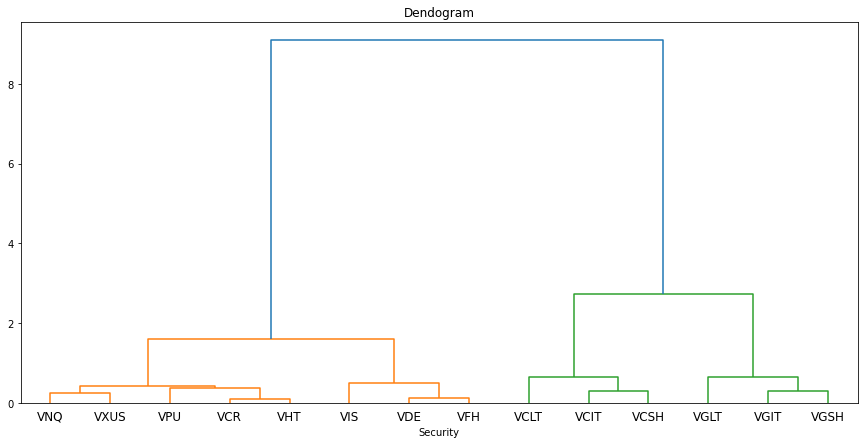

In [258]:
corr = returns_train.corr().values
dist_matrix= corr_dist(corr,type='cosine')
# print(dist_matrix)
link = linkage(dist_matrix,'ward')
plt.figure(figsize=(15,7))
dendrogram(link,labels = securities)
plt.xlabel('Security')
plt.title('Dendogram')

### Seriation algo

In [182]:
def quas_diag(link):
    security_count = len(link)+1
    link = link.astype(int)
    idx_sorted = pd.Series([link[-1,0],link[-1,1]])
    while idx_sorted.max() >= security_count: #keep addition securities to ordered index list until all are added
        idx_sorted.index = range(0,idx_sorted.shape[0]*2,2)
        df_0 = idx_sorted[idx_sorted>=security_count]
        i,j = df_0.index, (df_0.values - security_count)
        idx_sorted[i] = link[j,0]
        df_0 = pd.Series(link[j,1],index = i+1)
        idx_sorted = idx_sorted.append(df_0)
        idx_sorted = idx_sorted.sort_index()
        idx_sorted.index = range(idx_sorted.shape[0])
    return idx_sorted.tolist()

### Recursive Bisection

In [326]:
def ivp(cov):
    ivp = 1/np.diag(cov)
    ivp/=ivp.sum()
    return ivp

def clustervar(cov,citems):
    # print(cov,type(cov))
    cov_ = cov.iloc[citems,citems]
    w_ = ivp(cov_).reshape(-1,1)
    cvar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cvar

def recbipart(cov,idx_sorted):
    """"
    Computes allocation
    """
    weights = pd.Series(1,index=idx_sorted)
    cluster = [idx_sorted]
    while len(cluster)>0 :
        cluster = [i[j:k] for i in cluster for j,k in ((0,len(i)//2),(len(i)//2,len(i))) if len(i) >1]
        for i in range(0,len(cluster),2):
            cluster0 = cluster[i]
            cluster1 = cluster[i+1]
            cluster_var0 = clustervar(cov,cluster0)
            cluster_var1 = clustervar(cov,cluster1)
            a = 1-cluster_var0 / (cluster_var0+cluster_var1)
            weights[cluster0] *= a
            weights[cluster1] *= 1-a
    return weights


In [339]:
def hrpconstruct(data,dist_type = 'cosine'):
    corr = data.corr()
    cov = data.cov()
    dist_matrix= corr_dist(corr.values,type=dist_type)
    link = linkage(dist_matrix,'ward')
    plt.figure(figsize=(15,7))
    dendrogram(link,labels = securities)
    plt.title('Dendogram')
    plt.xlabel('Securities')
    sort_securities_idx = quas_diag(link)
    corr.index[sort_securities_idx].tolist()
    hrp = recbipart(cov,sort_securities_idx)
    return hrp.sort_index()

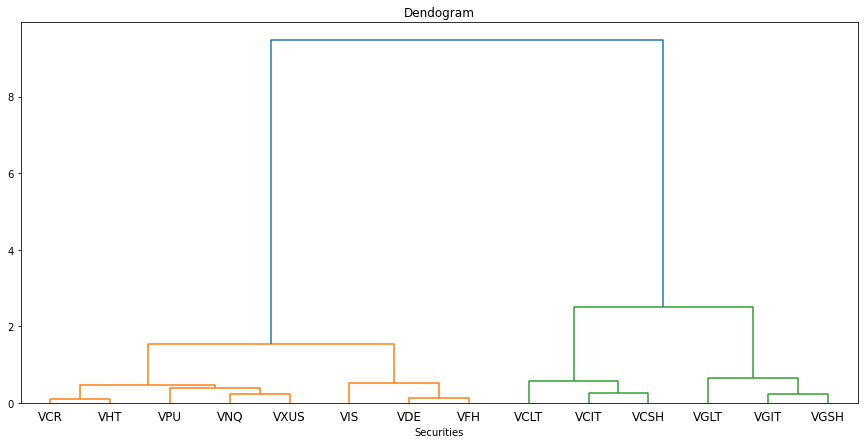

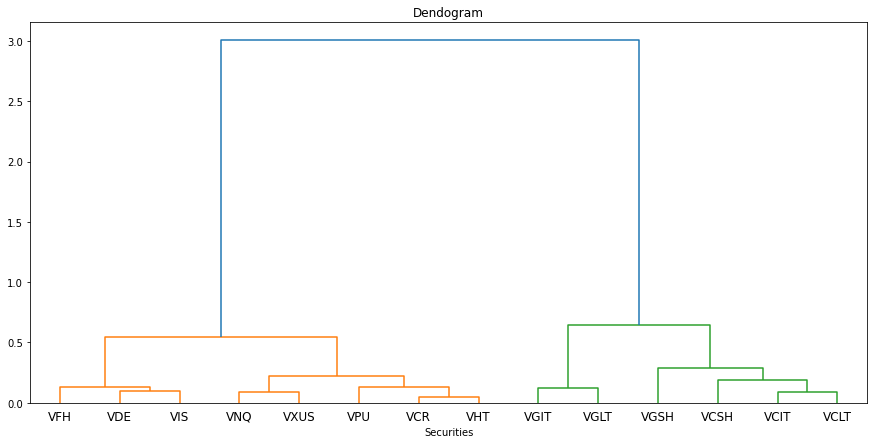

In [435]:
hrp_weights_cosine = hrpconstruct(returns_train)
hrp_weights_guassian = hrpconstruct(returns_train,dist_type='gaussian')
# hrp_weights_euclidean = hrpconstruct(returns_train,dist_type='euclidean')

### Benchmark - MMV

#### MMV Weight Calc

In [206]:
port = rp.Portfolio(returns = returns_train)
port.assets_stats(method_mu = 'hist',method_cov='hist')
mmv_w = port.optimization(model ='Classic',rm = 'MV', obj='Sharpe', hist = True)
mmv_w.T

,VCIT,VCLT,VCR,VCSH,VDE,VFH,VGIT,VGLT,VGSH,VHT,VIS,VNQ,VPU,VXUS
weights,0.0000%,0.0000%,11.4488%,82.4339%,0.0000%,6.0961%,0.0000%,0.0212%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


### Portfolio Allocation

In [436]:
hrp_w_df_cosine= pd.DataFrame(hrp_weights_cosine,columns=['weights'])
hrp_w_df_cosine.index = mmv_w.index

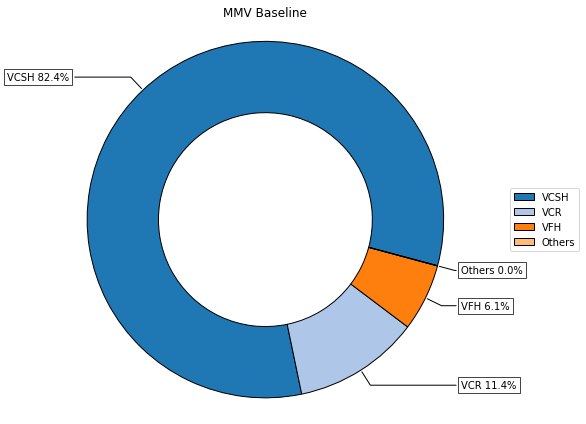

In [427]:
mmv_alloc_plot = rp.plot_pie(mmv_w,title = 'MMV Baseline')

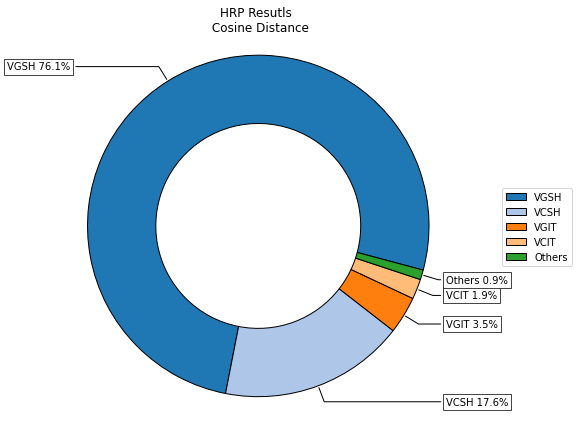

In [437]:
hrp_plot = rp.plot_pie(hrp_w_df_cosine,title = 'HRP Resutls \n Cosine Distance',others = .02)

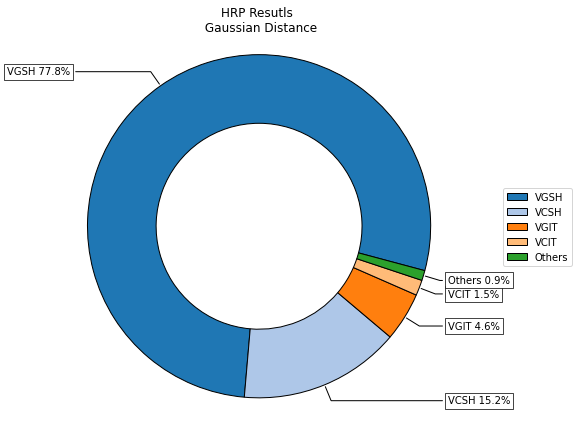

In [438]:
hrp_w_df_gaussian = pd.DataFrame(hrp_weights_guassian,columns=['weights'])
hrp_w_df_gaussian.index = mmv_w.index
hrp_plot = rp.plot_pie(hrp_w_df_gaussian,title = 'HRP Resutls \n Gaussian Distance',others = .02)

### Backtesting - Out of Sample

<AxesSubplot:xlabel='Date'>

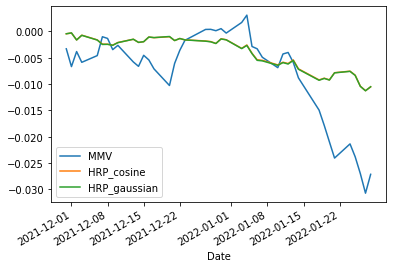

In [439]:
port_out_sample = pd.DataFrame(np.dot(mmv_w.T,returns_test.T.values))
port_out_sample = port_out_sample.transpose()
port_out_sample.index = returns_test.index
port_out_sample['HRP_cosine'] = np.dot(hrp_weights_cosine.T,returns_test.T.values)
port_out_sample['HRP_gaussian'] = np.dot(hrp_weights_guassian.T,returns_test.T.values)
port_out_sample.columns = ['MMV', "HRP_cosine","HRP_gaussian"]
port_out_sample.cumsum().plot()

In [441]:
stdev = port_out_sample.std()*np.sqrt(252)
##### CALCUALTE DOWNSIDE SEMIVAR
stdev

MMV            4.1596%
HRP_cosine     1.3474%
HRP_gaussian   1.3525%
dtype: float64